# Manipulating font data

By [Allison Parrish](https://www.decontextualize.com/)

This is a short notebook showing some techniques for loading data from TrueType/OpenType font files with [Flat](https://xxyxyz.org/flat) and then doing weird things with it using [Bezmerizing](https://github.com/aparrish/bezmerizing/). Make sure you've gone through these introductory notebooks before proceeding:

* [Flat and asemic writing](flat-asemic-writing.ipynb)
* [Lines and asemic writing](lines-and-asemic.ipynb)

We'll start with some introductory information about typography and font files.

## Typography terminology

First off, there are a number of terms that describe certain distances between parts of letterforms:

![Diagram of typography line terms](http://comptypo.decontextualize.com/public/images/800px-Typography_Line_Terms.svg.png)

Units of measurement:

* Point (1/72nd of an inch)
* Em (the width of a capital 'M' in a font)
* Pixel (the distance from one side of a pixel in a display to the other; may
  differ horizontally and vertically; some LCDs can have meaningful 'sub-pixel'
  addressing; "pixel" can mean something different on high-density displays)

Letter forms by their nature are analog (formed from continuous curves). *Rasterization* is the process of "sampling" the analog curves to a grid, for (e.g.) display on a screen.

## Components of TrueType/OpenType fonts

The most common digital formats for fonts are TrueType (`.ttf`) and OpenType (`.otf`), two closely related standards defined and implemented by [a dizzying amalgamation of Adobe, Apple and Microsoft during the 1990s and early
2000s](https://en.wikipedia.org/wiki/OpenType#History). Both are variants of the [SFNT format](https://en.wikipedia.org/wiki/SFNT) and share many of the same abstractions but differ in many particulars. I attempt to explain the important components of both formats in this section.

### Characters and glyphs

A text is often said to be made up of a string of characters. A character is the basic unit of writing: they're what you learn when you learn to write.

The most important part of a font file is the "glyphs," which are the individual, distinct marks that the font can produce. In many cases, there is a one-to-one correspondence between glyphs and characters (e.g., the glyph *c*
represents the character `c`) but some glyphs represent multiple characters (e.g., ligatures like ﬁ) and some characters may be represeted by more than one glyph (stylistic or contextual variants, e.g., the character `s` in early modern English, represented as *ſ* when found in the middle of a word, and *s* when found at the end).

For this reason, TTF/OTF fonts include information on how to map characters to glyphs. The most straightforward way to do this is with the [cmap table](https://docs.microsoft.com/en-us/typography/opentype/spec/cmap), which links a character (given as, e.g., Unicode code points) to a numbered glyph in
the font. [Substitution features](http://ilovetypography.com/OpenType/opentype-features.html) in OpenType allow the font designer to specify that certain sequences of characters should be represented with particular glyphs (like ligatures, but this feature also be creatively misused; see [Sans Bullshit Sans](https://pixelambacht.nl/2015/sans-bullshit-sans/) and [Doggy](https://www.swiss-miss.com/2012/09/doggy.html)). A font file may also specify other visual aspects of how the text should be rendered, like kerning (adjusting the horizontal and/or vertical space between pairs or longer sequences of characters), which in OpenType is specified in the [GPOS table](https://docs.microsoft.com/en-us/typography/opentype/spec/gpos).

Another aspect of appearance often specified in a font is [hinting](https://en.wikipedia.org/wiki/Font_hinting), which specifies how the vector data in the font should be adjusted during the rasterization process (i.e., displaying on a pixel-based screen), to ensure that the important parts of each glyph are displayed even when interpolated. The TrueType font format has [an absurdly sophisticated system for font hinting](https://docs.microsoft.com/en-us/typography/truetype/hinting), including a Turing-complete programming language, which has led to some [truly
spectacular security vulnerabilities](https://www.youtube.com/watch?v=jioFhWanFxU).

### Shape information

In TrueType and OpenType fonts, the shape of a glyph is specified using data in an sfnt table (called either `glyf` or `CFF `). The point of the data is to define the lines and curves that form the outline of the shapes. The actual formats of these tables are quite frankly baroque and overly complicated; see the [`glyf` specification](https://developer.apple.com/fonts/TrueType-Reference-Manual/RM06/Chap6glyf.html) and the [`CFF `
specification](https://docs.microsoft.com/en-us/typography/opentype/spec/cff). For our purposes, it's not worth talking about the details, since the library we'll be using to parse the font files will smooth everything over for us.

In general, the outline of a glyph is comprised of a series of one or more contours (shapes), which are in turn comprised of lines and curves (with 2D coordinates). In TrueType and OpenType fonts, the start/end positions are
integers on a grid whose resolution is defined by the font itself (e.g., 2048 units per em), with the origin generally at the lower left-hand corner of the glyph.

This illustration from the [FreeType documentation](https://www.freetype.org/freetype2/docs/glyphs/index.html) names
some of the metrics associated with a (horizontal) glyph. For example, the character's *bearing* is a measure of how far from the origin the glyph is; the *advance* of a character controls how much the "pen" should be moved forward
after drawing the character; this may be different from the character's *width*.

![OpenType metrics diagram](http://comptypo.decontextualize.com/public/images/metrics.png)

### Curves

A contour specification consists of lines and curves. Representing a line as data is very easy; you just need to indicate the coordinates of the start and end of the segment. Representing a curve is a little bit more difficult, and
there are multiple strategies for accomplishing this. The most common way to represent curves is as [Bézier
curves](https://en.wikipedia.org/wiki/B%C3%A9zier_curve). Named after French engineer [Pierre Bézier](https://en.wikipedia.org/wiki/Pierre_B%C3%A9zier), who used the math behind the curve in industrial design in the 1960s, a Bézier curve consists of two *anchor points* and a series of *control points*.  The anchor points define the beginning and ending of the curve, and the control points define the extent of the curvature. A Bézier curve with one control point is called *quadratic* and one with two control points is called *cubic*. Higher order curves are possible, but because the use of cubic curves is so widespread in software, the term "Bézier" is often used specifically to mean *cubic* Bézier curves. (This reflects the usage in, e.g., p5.js: see [bezier()](https://p5js.org/reference/#/p5/bezier) and [quadraticVertex()](https://p5js.org/reference/#/p5/quadraticVertex) in the
documentation.)

The following demo lets you play with a cubic Bézier's anchor and control points: [(Cubic) Bezier curve demo](https://editor.p5js.org/allison.parrish/sketches/H1QQ3Nt67)

And the demo below does the same for a quadratic curve: [Quadratic curve demo](https://editor.p5js.org/allison.parrish/sketches/HysPl9FT7)

Here's [a helpful introduction to the math behind Bézier curves](https://pomax.github.io/bezierinfo/), how they're represented as data and how to efficiently rasterize them. (You don't need to read or understand all of this in order to make use of Bézier curves, but it's helpful to read at least the first few sections.) The author of that tutorial has also made a [wonderful library for working with Bézier curves in JavaScript](https://pomax.github.io/bezierjs/). 

The distinction between quadratic and cubic curves is important, because TrueType fonts (with `glyf` tables) *only* support quadratic curves, while OpenType fonts (specifically those that use the `CFF ` table) make use of cubic curves. If you want to be able to draw glyphs from either format, you have to be able to draw both kinds of curves.

### Counters and cutouts

Many glyph outlines consist of more than one contour: the letter `j` for example has a contour for the body of the letter and a separate (non-overlapping) contour for the dot.

Additionally, some glyph outlines have have closed [counters](https://en.wikipedia.org/wiki/Counter_(typography)): contours of the glyph that are completely enclosed within another contour. (The "hole" in the letter `O` is an example; a capital `B` has two counters.) Some glyph outlines, like `®`, have contours within contours within contours!

So the question arises: in a glyph outline, how do you know which contours should be filled in, and which should be "cut out"? (Otherwise stated: how do you know which points are "inside" the letter and should be filled in, and
which points are "outside" the letter and should be left blank?)

This is one of the trickier parts of rendering a glyph. TrueType `glyf` fonts use one strategy: if the points in a contour are defined in a clockwise fashion, then the shape should be filled; if they're defined in a counter-clockwise fashion, then the shape should be cut out. In OpenType `CFF ` fonts, contours are considered cutouts if they're contained inside an odd number of other paths. ([Source](https://github.com/opentypejs/opentype.js/issues/347).) In either case, finding out whether a contour should be cut out or filled in depends on doing some math on the points and curves of the contours themselves.

### Variable fonts

Recent versions of the OpenType standard include support for ["variable" fonts](https://simoncozens.github.io/fonts-and-layout/opentype.html#opentype-font-variations). Variable fonts contain multiple "masters" (i.e., different versions of the same glyphs), alongside information about how to interpolate between the points in those masters. The end goal of variable fonts is to make it possible to dynamically adjust (e.g.) the weight of a font (without having to include separate font data for each weight). As of this writing, support for variable fonts remains incomplete (even in some web browsers), and the library we're using to work with TrueType/OpenType files (sadly) does not support variable fonts. But it's worth knowing about! This [Variable Fonts website](https://v-fonts.com/) has a ton of variable fonts you can play around with to get an idea for how they work.

## Code preliminaries

Whew! With all of that in mind, we can start programming. Before we begin, some preliminary imports from Flat, Bezmerizing, and Drawbot:

In [1]:
from flat import document, rgb, rgba, font, strike, shape
from flat.command import moveto, quadto, curveto, lineto, closepath
from bezmerizing import Polyline, Path
import numpy as np
from copy import copy
import drawBot as draw

And some functions from `numpy` which we'll use for generating random numbers.

In [2]:
from numpy.random import uniform, normal, choice

Also, because drawbot needs the same lines to start and end a drawing, let's make functions to save ourselves from typing too much. This incorporates the IPython module:

In [3]:
from IPython.display import Image, display


def startdraw(canvas_width,canvas_height):
    draw.newDrawing()
    draw.newPage(canvas_width, canvas_height)
    
def show():
    draw.saveImage("drawBotImage.png")
    draw.endDrawing()
    drawing = Image(filename = "drawBotImage.png")
    display(drawing)

## Flat paths

Flat has a concept of a "path," which is a Python list of `command`s. Five such commands are supported:

* `moveto(x, y)`: Moves pen to x, y.
* `lineto(x, y)`: Moves pen to x, y, drawing a line along the way.
* `quadto(x1, y1, x, y)`: Draws a quadratic Bezier curve from current pen position to x, y, using control point x1, y1.
* `curveto(x1, y1, x2, y2, x, y)`: Draws a cubic Bezier curve from current point to x, y, using control points x1, y1 and x2, y2.
* `closepath`: Closes the current subpath.

To draw a path, create a list of `command`s and pass them to a `shape` object's `path` command. For example, to draw a little strange triangle:

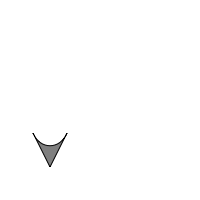

In [4]:
startdraw(200,200)

draw.fill (0,0,0,0.5)
draw.stroke (0,0,0,1)

path = draw.BezierPath()
path.moveTo((50, 33))
path.lineTo((67, 67))
path.curveTo((60, 50),(40, 50), (33, 67))
path.closePath()

draw.drawPath(path)

show()

A potential drawback to specifying paths is that the coordinates are hard-coded, making it difficult to do things like draw the path at a different size or at a different location on the canvas. To mitigate this drawback, we'll want to be able to apply [affine transformations](https://en.wikipedia.org/wiki/Affine_transformation) to paths, such as translation, rotation, scale, etc. Flat natively supports a "transformation matrix" to apply affine transformations, but that support is a little bit clunky and requires you to hand-code even simple transformations.

> If you need an explanation of affine transformations or the transformation matrix, I recommend this [helpful introduction](https://www.alanzucconi.com/2016/02/10/tranfsormation-matrix/)—not specific to Flat, but the concepts are the same.

To transform a path, call one of the `Path` object's transformation functions: `.translate()`, `.rotate()`, or `.scale()`. This will return a new `Path` with the transformation applied to copies of the commands in the original path. (The commands in the original path will be unchanged.) The code below shows the effect of the commands, with the transformed shapes drawn with slight transparency:

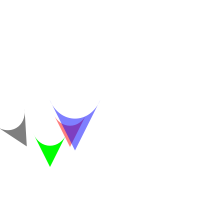

In [5]:
startdraw(200,200)

draw.fill(0,1,0,1) # Green color fill
draw.drawPath(path)


# move the path up and to the left
translated_path = path.copy()
translated_path.translate(20, 20)
draw.fill(1,0,0,0.5) #color Red 
draw.drawPath(translated_path)

# scale the path by a factor of 1.5x
scaled_path = path.copy()
scaled_path.scale(1.5,1.5)
draw.fill(0,0,1,0.5) #blue
draw.drawPath(scaled_path)

# rotate the path
rotated_path = path.copy()
rotated_path.rotate(30)
draw.fill(0,0,0,0.5) #black
draw.drawPath(rotated_path)


show()

You'll notice that all of these transformations use the origin (i.e., coordinate `(0, 0)`) as the "center" of the transformation, so (e.g.) the "center" of the `rotate()` transformation is in the upper left-hand corner of the screen. For this reason, when specifying paths for use with transformations, programmers often intentionally center the figure around the origin.

In [6]:
doodad_center = draw.BezierPath()
doodad_center.moveTo((0, -17))
doodad_center.lineTo((17, 17))
doodad_center.curveTo((10, 0),(-10, 0), (-17, 17))
doodad_center.closePath()

(note by Lynne: In other words, you're redrawing the shape to be drawn around the 0,0 origin point. Drawing the 'doodad center' here:)

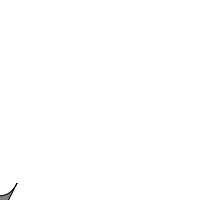

In [7]:
startdraw(200,200)

draw.fill (0,0,0,0.5)
draw.stroke (0,0,0,1)
draw.drawPath(doodad_center)

show()

The cell below shows a series of chained transformations on this centered path:

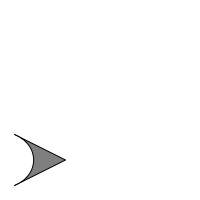

In [8]:
startdraw(200,200)
draw.fill (0,0,0,0.5)
draw.stroke (0,0,0,1)

scaled_path = doodad_center.copy()
scaled_path.scale(1.5,1.5)
scaled_path.rotate(90)
scaled_path.translate(40, 40)

draw.drawPath(scaled_path)

show()

Example of chaining transformations in a loop:

In [9]:
width = 500
height = 30
startdraw(width,height)
draw.fill (0,0,0,0.5)
draw.stroke (0,0,0,1)
n = 20

for i in range(n):
    scaled_path = doodad_center.copy()
    scaled_path.scale(0.6)
    scaled_path.rotate(i*5)
    scaled_path.translate(width/n*0.5 + (width / n)*i, height/2)
    draw.drawPath(scaled_path)

show()

## Drawing strings with Drawbot

Drawbot has a handful of helpful functions for drawing strings to the screen with a given font. You need to download the font file for the font you want to use, put it in the same directory as this notebook, and then call `installFont` as below. We'll use a font from Google's [Noto collection](https://www.google.com/get/noto/).

From the Drawbot Documentation:

`installFont(path): Install a font with a given path and the postscript font name will be returned. The postscript font name can be used to set the font as the active font.Fonts are installed only for the current process. Fonts will not be accesible outside the scope of drawBot. All installed fonts will automatically be uninstalled when the script is done.`

In [10]:
#set the path to a font file
path = "./NotoSans-Regular.ttf"
NotoSans = draw.installFont(path)


Here's some DrawBot functions to help you out.

`text(txt, (x, y), align=None)` : Draw a text at a provided position

`textBox(txt, box, align=None) ` :Draw a text in a provided rectangle

Plus, the textbox will get you whatever was not printed in the string!

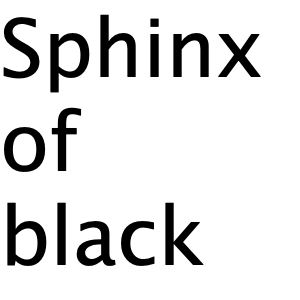

quartz, judge my vow.


In [11]:
startdraw(300,300)
draw.fill (0,0,0,1) # no fill
draw.fontSize(80)

overflow = draw.textBox("Sphinx of black quartz, judge my vow.", (0,0,300,300), align='left')
show()
print(overflow)

## Glyph paths

Drawbot lets us access the points in the glyphs in the font directly. With the `.text` method, we can assign the `BezierPath` object. Keep in mind that some letters have more than 1 contour, so we will have to call all contours.

Note: a `contour` object also has an attribute `contour.open` and `contour.clockwise` [link source](https://forum.drawbot.com/topic/136/bezierpath-contours-and-segments/3?_=1585942692791)

In [12]:
path = draw.BezierPath()
path.text("a", font = NotoSans, fontSize = 500)

for contour in path.contours:
    print("Here is a contour")
    print("contour.open is " + str(contour.open))
    print("contour.clockwise is " + str(contour.clockwise))
    for points in contour:
        print(points)

Here is a contour
contour.open is False
contour.clockwise is True
[(184.814453125, 33.69140625)]
[(156.00571533203123, 7.16132568359375), (128.255341796875, -6.103515625), (101.5625, -6.103515625)]
[(79.58973388671875, -6.103515625), (61.36074951171875, 0.7730432128906255), (46.875, 14.5263671875)]
[(32.38925048828125, 28.279691162109373), (25.146484375, 45.65419189453125), (25.146484375, 66.650390625)]
[(25.146484375, 95.6218896484375), (37.31270385742187, 117.87915405273438), (61.6455078125, 133.4228515625)]
[(85.97831176757812, 148.96654907226562), (120.84938232421874, 156.73828125), (166.259765625, 156.73828125)]
[(177.734375, 156.73828125)]
[(177.734375, 188.720703125)]
[(177.734375, 219.48257568359378), (161.9467724609375, 234.86328125), (130.37109375, 234.86328125)]
[(104.980341796875, 234.86328125), (77.55548583984375, 227.05085937500002), (48.095703125, 211.42578125)]
[(48.095703125, 251.220703125)]
[(80.48518798828125, 264.40436279296875), (110.83970214843751, 270.99609375), 

Via Frederik on the [forum](https://forum.drawbot.com/topic/136/bezierpath-contours-and-segments/2?_=1585942692799): "a segment always represent a line with a single point and a bezier curve with 3 points (2 off curves and one oncurve)"

(abbreviated from original notebook)

You'll notice that y-coordinates are mostly negative. That's because glyphs in fonts are generally drawn with the origin of the coordinate system (`0, 0`) in the *lower left-hand* corner.

> A quadratic Bézier curve has one control point; a cubic Bézier has two control points. TrueType fonts (TTFs) use quadratic Bézier curves exclusively; OpenType fonts (generally) use cubic Bézier curves.

The coordinates of points in TrueType and OpenType fonts are always specified as integers. The value of these integers doesn't correspond with any real-world unit; instead, each font must specify a "units per em" parameter that indicates how many units in the font's coordinate system correspond with an em-width. Using fontTools, you can access this with the `.unitsPerEm` attribute of the font object after you extract it from the cmap:

In [13]:
from fontTools.ttLib.tables._c_m_a_p import CmapSubtable
from fontTools.ttLib import TTFont

font = TTFont("./NotoSans-Regular.ttf")
units_per_em = font['head'].unitsPerEm

print(units_per_em)

1000


## fontTools ##
What is fontTools you say? Let's take a quick detour into fontTools. The [fontTools Python library](https://rsms.me/fonttools-docs/) is useful for grabbing information from font files. 

The above `contour` function from drawBot lets you grab all the points, but it may not give you enough information. Let's use FontTools to help us.

In [14]:
from fontTools.pens.recordingPen import RecordingPen, DecomposingRecordingPen
font = TTFont("./NotoSans-Regular.ttf")
glyph_a = font.getGlyphSet()['a']

p = RecordingPen()
glyph_a.draw(p)
p.value

[('moveTo', ((288, 545),)),
 ('qCurveTo', ((386, 545), (480, 459), (480, 365))),
 ('lineTo', ((480, 0),)),
 ('lineTo', ((416, 0),)),
 ('lineTo', ((399, 76),)),
 ('lineTo', ((395, 76),)),
 ('qCurveTo', ((360, 32), (282, -10), (215, -10))),
 ('qCurveTo', ((142, -10), (46, 67), (46, 149))),
 ('qCurveTo', ((46, 229), (172, 316), (303, 320))),
 ('lineTo', ((394, 323),)),
 ('lineTo', ((394, 355),)),
 ('qCurveTo', ((394, 422), (336, 474), (283, 474))),
 ('qCurveTo', ((241, 474), (165, 449), (132, 433))),
 ('lineTo', ((105, 499),)),
 ('qCurveTo', ((140, 518), (236, 545), (288, 545))),
 ('closePath', ()),
 ('moveTo', ((393, 262),)),
 ('lineTo', ((314, 259),)),
 ('qCurveTo', ((214, 255), (137, 199), (137, 148))),
 ('qCurveTo', ((137, 103), (192, 61), (235, 61))),
 ('qCurveTo', ((302, 61), (393, 136), (393, 214))),
 ('closePath', ())]

Thankfully, placing all of this on the screen is relatively easy with drawbot.

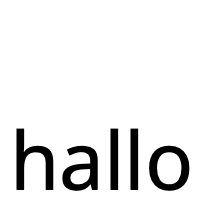

In [15]:
startdraw(200,200)
draw.font("NotoSans-Regular.ttf",80)
draw.text("hallo", (10,10))
show()

You can also draw the letter(s) as a `BezierPath` object! This can come in handy if you want to use the Bezier for something (like writing inside the outlines.)

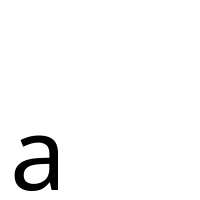

In [16]:
startdraw(200,200)
path = draw.BezierPath()
path.text("a", font = NotoSans, fontSize = 100)
path.translate(10,10) ## move to not cut off
draw.drawPath(path)
show()

### The character map and advances

fontTools convieinetly lets us grab the Glyph ID if we need via `TTFont`. Keep in mind, that Glyph IDs are not the same as unicode. Glyph IDs are the order in which the glyphs have been arranged in a font file, and may not be the same across different fonts.

In [17]:
ord("a") ## Unicode codepoint 

97

In [18]:
from fontTools.ttLib import TTFont
font.getGlyphID('a') ## Glyph ID

68

In font files, there are 'widths' of each glyph. They include the left and right sidebearings. Access the advances with the font object's `.width` attribute:

In [19]:
glyph_a = font.getGlyphSet()['a']
glyph_a.width

561

In [20]:
glyph_a = font.getGlyphSet()[chr(97)] ## This also works
glyph_a.width

561

These two helper functions get the path commands for a given character and the advance for a given character:

In [21]:
font = TTFont("./NotoSans-Regular.ttf")

def glyphcommands(f, ch):
    glyph = f.getGlyphSet()[ch]
    p = RecordingPen()
    glyph.draw(p)
    return p.value

def advancefor(f, ch):
    glyph = f.getGlyphSet()[ch]
    return glyph.width

The path for the letter `a`:

In [22]:
glyphcommands(font, "a")

[('moveTo', ((288, 545),)),
 ('qCurveTo', ((386, 545), (480, 459), (480, 365))),
 ('lineTo', ((480, 0),)),
 ('lineTo', ((416, 0),)),
 ('lineTo', ((399, 76),)),
 ('lineTo', ((395, 76),)),
 ('qCurveTo', ((360, 32), (282, -10), (215, -10))),
 ('qCurveTo', ((142, -10), (46, 67), (46, 149))),
 ('qCurveTo', ((46, 229), (172, 316), (303, 320))),
 ('lineTo', ((394, 323),)),
 ('lineTo', ((394, 355),)),
 ('qCurveTo', ((394, 422), (336, 474), (283, 474))),
 ('qCurveTo', ((241, 474), (165, 449), (132, 433))),
 ('lineTo', ((105, 499),)),
 ('qCurveTo', ((140, 518), (236, 545), (288, 545))),
 ('closePath', ()),
 ('moveTo', ((393, 262),)),
 ('lineTo', ((314, 259),)),
 ('qCurveTo', ((214, 255), (137, 199), (137, 148))),
 ('qCurveTo', ((137, 103), (192, 61), (235, 61))),
 ('qCurveTo', ((302, 61), (393, 136), (393, 214))),
 ('closePath', ())]

... and its advance:

In [23]:
advancefor(font, "a")

561

That being said, what happens when you try to get paths for composite letters, like `ā`?

In [24]:
glyphcommands(font, 'atilde')

[('addComponent', ('a', (1, 0, 0, 1, 0, 0))),
 ('addComponent', ('tilde', (1, 0, 0, 1, 57, 0)))]

As you can see, it uses components and doesn't give us a separate path. In this example, we need to use the `Decomposing Recording Pen` since we need to get all the points.

In [25]:
font = TTFont("./NotoSans-Regular.ttf")

def glyphcommands(f, ch):
    glyphset = f.getGlyphSet()
    glyph = glyphset[ch]
#     p = RecordingPen() ## this doesn't count components
    p = DecomposingRecordingPen(glyphset)
    glyph.draw(p)
    return p.value

In [26]:
glyphcommands(font, "atilde")

[('moveTo', ((288, 545),)),
 ('qCurveTo', ((386, 545), (480, 459), (480, 365))),
 ('lineTo', ((480, 0),)),
 ('lineTo', ((416, 0),)),
 ('lineTo', ((399, 76),)),
 ('lineTo', ((395, 76),)),
 ('qCurveTo', ((360, 32), (282, -10), (215, -10))),
 ('qCurveTo', ((142, -10), (46, 67), (46, 149))),
 ('qCurveTo', ((46, 229), (172, 316), (303, 320))),
 ('lineTo', ((394, 323),)),
 ('lineTo', ((394, 355),)),
 ('qCurveTo', ((394, 422), (336, 474), (283, 474))),
 ('qCurveTo', ((241, 474), (165, 449), (132, 433))),
 ('lineTo', ((105, 499),)),
 ('qCurveTo', ((140, 518), (236, 545), (288, 545))),
 ('closePath', ()),
 ('moveTo', ((393, 262),)),
 ('lineTo', ((314, 259),)),
 ('qCurveTo', ((214, 255), (137, 199), (137, 148))),
 ('qCurveTo', ((137, 103), (192, 61), (235, 61))),
 ('qCurveTo', ((302, 61), (393, 136), (393, 214))),
 ('closePath', ()),
 ('moveTo', ((97, 606),)),
 ('qCurveTo', ((103, 665), (160, 734), (207, 734))),
 ('qCurveTo', ((237, 734), (290, 705), (338, 677), (359, 677))),
 ('qCurveTo', ((382

### Application: Glyph complexity analysis

One potential small application of this data is the ability to analyze the font's glyphs. We can get a full list of all of the glyphs that are in the font with `.getGlyphNames`.

In [27]:
font.getGlyphNames()

['.notdef',
 'A',
 'AE',
 'AEacute',
 'Aacute',
 'Abreve',
 'Acircumflex',
 'Adieresis',
 'Agrave',
 'Alpha',
 'Alphatonos',
 'Amacron',
 'Aogonek',
 'Aogonek.loclNAV',
 'Aring',
 'Aringacute',
 'Atilde',
 'B',
 'Beta',
 'C',
 'CDoubleStruck',
 'CR',
 'Cacute',
 'Ccaron',
 'Ccedilla',
 'Ccircumflex',
 'Cdot',
 'Cfraktur',
 'Chi',
 'D',
 'Dcaron',
 'Dcroat',
 'E',
 'Eacute',
 'Ebreve',
 'Ecaron',
 'Ecircumflex',
 'Edieresis',
 'Edotaccent',
 'Egrave',
 'Emacron',
 'Eng',
 'Eng.alt1',
 'Eng.alt2',
 'Eng.alt3',
 'Eogonek',
 'Eogonek.loclNAV',
 'Epsilon',
 'Epsilontonos',
 'Eta',
 'Etatonos',
 'Eth',
 'Euro',
 'F',
 'G',
 'Gamma',
 'GammaDoubleStruck',
 'Gbreve',
 'Gcircumflex',
 'Gdot',
 'H',
 'HDoubleStruck',
 'Hbar',
 'Hcircumflex',
 'Hfraktur',
 'I',
 'IJ',
 'Iacute',
 'Ibreve',
 'Icircumflex',
 'Idieresis',
 'Idotaccent',
 'Ifraktur',
 'Igrave',
 'Imacron',
 'Iogonek',
 'Iogonek.loclNAV',
 'Iota',
 'Iotadieresis',
 'Iotatonos',
 'ItalicDDoubleStruck',
 'ItalicdDoubleStruck',
 'Italice

We can also find out the character set of this font file with the `len` function:

In [28]:
len(font.getGlyphNames())

3246

Let's add all the glyphs in one list:

In [29]:
glyph_names = [i for i in font.getGlyphNames()]

Let's quickly find out which character in the font is the most complex—i.e., which glyph has the largest number of commands in its path. The downside of just counting how many things are in `glyphcommands(font, "a")` is that the curved points which have multiple points will only count as 1 command. So in order to calculate complexity, we'll need to count how many points are in the glyph path.

In [30]:
glyph_paths = []
for glyphs in glyph_names:
    count = 0
    for i,j in glyphcommands(font, glyphs):
        for k in j:
            count += 1
    glyph_paths.append((glyphs,count))

The resulting data structure looks like this:

In [31]:
glyph_paths[:12]

[('.notdef', 8),
 ('A', 18),
 ('AE', 20),
 ('AEacute', 32),
 ('Aacute', 30),
 ('Abreve', 32),
 ('Acircumflex', 37),
 ('Adieresis', 44),
 ('Agrave', 30),
 ('Alpha', 18),
 ('Alphatonos', 30),
 ('Amacron', 22)]

... which tells us that A, the glyph at index 1 has 18 points in its path; the Adieresis glyph at index 7 has 44 elements, etc. The following code sorts this list in reverse order by the value in the second element of the tuple, grabbing just the top ten:

In [32]:
glyphs_by_complexity = sorted(glyph_paths, key=lambda x: x[1], reverse=True)[:10]
glyphs_by_complexity

[('uniA66E', 301),
 ('uni2E19', 202),
 ('uni034F', 184),
 ('uni210B', 166),
 ('uni214C', 166),
 ('uni212C', 160),
 ('uni211B', 156),
 ('uniFFFC', 147),
 ('Rfraktur', 138),
 ('uni2131', 138)]

To get the index of just the most complex character and see Glyph ID:

In [33]:
most_complex_index = glyphs_by_complexity[0][0]

print ('most_complex_index is ' + str(most_complex_index))
print ("Glyph ID is " + str(font.getGlyphID(most_complex_index)))

most_complex_index is uniA66E
Glyph ID is 2418


Now, we need to convert the 'uni' part to 0x, to make sure Python can read it. ALSO, keep in mind that unicode numbers are hex, so you have to specify to use base-16 (as opposed to the usual 10 that we use with Arabic numerals).

In [34]:
convert_index_name = int(str(most_complex_index).replace("uni","0x"),16)
print ("Converted name is : " + str(convert_index_name))
print ("It looks like this : " + str(chr(convert_index_name)))

Converted name is : 42606
It looks like this : ꙮ


Note: It may look like nothing printed after 'it looks like this: '. If it is,it's just because the font that is getting used in Jupyter Notebook to render the output doesn't support this character.

Let's draw it to see what this glyph looks like!

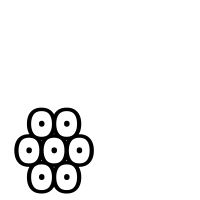

In [35]:
startdraw(200,200)
path = draw.BezierPath()
path.text(str(chr(convert_index_name)), font = NotoSans, fontSize = 100)
path.translate(10,20) ## move to not cut off
draw.drawPath(path)
show()

Whoa! What is that wonderful thing? In order to find out, we need some way to track the glyph index back to the Unicode character it represents.

Using Python's `unicodedata` module, we can get the name and codepoint for this character:

In [36]:
from unicodedata import *
print(name(str(chr(convert_index_name)))) #Get Unicode Name
print(ord(str(chr(convert_index_name)))) #Get codepoint of Unicode

CYRILLIC LETTER MULTIOCULAR O
42606


We can also lookup the char of a given name too:

In [37]:
char = lookup("CYRILLIC LETTER MULTIOCULAR O")
print(char)

ꙮ


It's the [multiocular O](https://en.wikipedia.org/wiki/Multiocular_O) (ꙮ), a variant of the Cyrillic letter O found in a handful of medieval manuscripts and also probably the coolest codepoint in Unicode.


### Visualizing glyph complexity

Let's build on this a little bit to make some asemic writing. Or maybe this is more like a text visualization experiment? I'm not sure! I'm going to write some code that "rewrites" a text by replacing each character with a rectangle whose fill color corresponds to the complexity of that character's corresponding glyph, and whose width corresponds to the advance of the character.

We'll use Robert Frost's "The Road Not Taken," [included in this repository as frost.txt](frost.txt).

The code below does a couple of tricky things. Some of those tricky things are layout-related, which we'll cover in more detail in the following section.

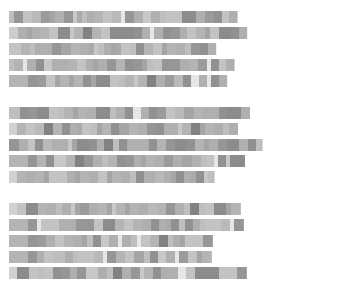

In [38]:
startdraw(360,288)
border = 9 # 1/8in
lineheight = 16 # size of each line
rectsize = 12 # size of each rectangle
yoff = border  
xoff = border
for line in open("frost.txt"):
    line = line.strip() # remove trailing whitespace
    for ch in line:
        path_len = len(glyphcommands(font, ch))
        val = (255 - (path_len * 5))/255
        advance = advancefor(font, ch) / font['head'].unitsPerEm * lineheight
        draw.fill(val)
        draw.rect(xoff, yoff, advance, rectsize)
        xoff += int(advance)
    xoff = border
    yoff += lineheight
show()

## FIX LATER, HAD TO STRIP SPACE AND PUNCTUATION

### Rendering a string "by hand"

Using `glyphcommands()` and `advancefor()`, you can draw an entire string on the screen. The most simple technique to render a string of characters in a Roman-derived alphabet (like English):

* Keep track of the current cursor position.
* For each character in the string:
  * Draw the glyph associated with this character at the current cursor position.
  * Move the current cursor position to the right by the amount of the character's advance.

It should be noted that there are many important drawbacks to this approach:

* It only works with left-to-right writing
* Doesn't take into account kerning, ligatures, etc.

Even with simple left-to-right alphabets, there's more to think about than what we've implemented here. For example, this approach doesn't handle things like text alignment, line breaks, margins, indentation, etc. Still, this is a good starting point.

> The task of taking a sequence of characters and turning it into a sequence of glyphs is called "text shaping," and it's a very complicated process, moreso for scripts like Arabic that rely heavily on ligatures. [HarfBuzz](https://en.wikipedia.org/wiki/HarfBuzz) is a well-known open source library for doing text shaping, and it has [Python bindings](https://github.com/harfbuzz/uharfbuzz).

#### One character at a time

The code below implements this simple string layout procedure. It moves the pen by the character's advance on the x axis and draws the next character at the new position, using `translate()` to translate the path commands to the appropriate place.

But first, let's make a `draw_paths` function to make our lives easier via the 'glyph commands' we were using earlier.

In [39]:
def draw_paths(font,char,scale_num,trans_x,trans_y):
    path_orig = glyphcommands(font, char)
    paths = []
    for i in path_orig:
        if i[0] == 'moveTo':
            path = draw.BezierPath()
            path.moveTo((i[1][0]))
    #         print('startpath'+str((i[1][0])))
        if i[0] == 'lineTo':
            path.lineTo((i[1][0]))
    #         print('lineto' +str(i[1][0]))
        if i[0] == 'qCurveTo':
            path.qCurveTo(*(i[1]))
    #         print('qCurveTo' + str(i[1]))
        if i[0] == 'closePath':
            path.closePath()
            paths.append(path)
    #         print('closepath')
    if len(paths) > 1:
        finalpath = paths[0].difference(paths[1])
    else: 
        finalpath = paths[0]
    finalpath.scale(scale_num)
    finalpath.translate(trans_x,trans_y)
    return finalpath

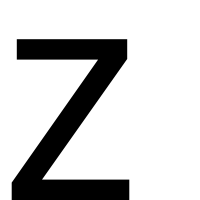

In [40]:
startdraw(200,200)
draw.drawPath(draw_paths(font,'z',0.3, 0, 0))
show()

In [41]:
s = "quartzyfoxes"

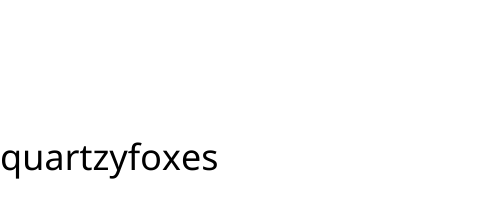

In [42]:
startdraw(500,200)
units_per_em = font['head'].unitsPerEm
factor = 36 / units_per_em
cx = 0
for ch in s:
    draw.drawPath(draw_paths(font,ch,factor, cx, 30))
    cx += advancefor(font, ch) * factor
show()

Because we're drawing one character at a time, we can introduce some random variation to the character positions and scale:

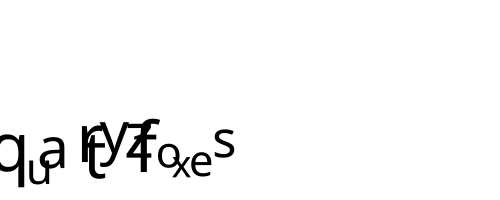

In [43]:
startdraw(500,200)
units_per_em = font['head'].unitsPerEm
factor = 36 / units_per_em
cx = 0
for ch in s:
    draw.drawPath(draw_paths(font,ch,factor*uniform(1,2), cx+normal(0,10), 30+normal(0,10)))
    cx += advancefor(font, ch) * factor
show()

We don't have to draw the characters on the screen in a straight line either:

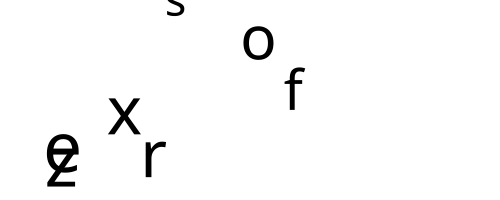

In [44]:
startdraw(500,200)
units_per_em = font['head'].unitsPerEm
factor = 36 / units_per_em
cx = 0
for ch in s:
    draw.drawPath(draw_paths(font,ch,factor*uniform(1,2), factor+uniform(300), factor+uniform(300)))
    cx += advancefor(font, ch) * factor
show()

#### Making one big path

Another approach is to build one larger `Path` object that combines the paths of each of the individual letters, and draw that instead. This has some interesting advantages that we'll look at later on. The following cell defines a function `combine_path()` that takes a font and a string and returns a path that combines the paths for each character in the string:

In [45]:
from itertools import chain
def combine_path(font, s,scale):
    text_paths = []
    cx = 0
    for ch in s:
        glyph_path = draw_paths(font, ch, scale, cx, 0)
        text_paths.append(glyph_path)
        cx += advancefor(font, ch)*scale
    combined = draw.BezierPath()
    for i in text_paths:
        combined.appendPath(i)
    return combined

Call it like this:

In [46]:
qf_path = combine_path(font, "quartzyfoxes",0.1)

The resulting path has a lot of commands:

In [47]:
len(qf_path)

16

But you can draw it like any other path:

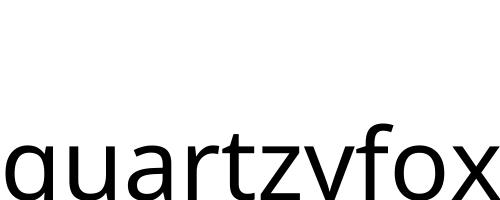

In [48]:
startdraw(500,200)
units_per_em = font['head'].unitsPerEm
factor = 36 / units_per_em

draw.drawPath(qf_path)

show()


### Modifying paths

Of course, nothing is forcing us to render these glyph paths exactly as they're stored in the font! We can modify them and reinterpret them. Let's take a character like `z`:

Here's what it looks like:

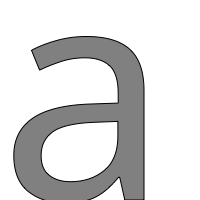

In [49]:
path_orig = glyphcommands(font, "a")
startdraw(200,200)

paths = []
for i in path_orig:
    if i[0] == 'moveTo':
        path = draw.BezierPath()
        path.moveTo((i[1][0]))
#         print('startpath'+str((i[1][0])))
    if i[0] == 'lineTo':
        path.lineTo((i[1][0]))
#         print('lineto' +str(i[1][0]))
    if i[0] == 'qCurveTo':
        path.qCurveTo(*(i[1]))
#         print('qCurveTo' + str(i[1]))
    if i[0] == 'closePath':
        path.closePath()
        paths.append(path)
#         print('closepath')

finalpath = paths[0].difference(paths[1])
finalpath.scale(0.3) #let's scale it down!
draw.fill(0.5)
draw.stroke(0)
draw.drawPath(finalpath)
show()

We can mess around with the path by *modifying the path commands*. For example, the following code loops over each of the commands in the path and adds random noise to the `x` and `y` coordinates:

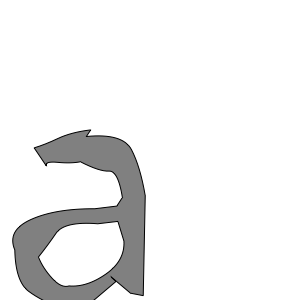

In [50]:
path_orig = glyphcommands(font, "a")
startdraw(300,300)

disturbance = 15
paths = []
for i in path_orig:
    if i[0] == 'moveTo':
        path = draw.BezierPath()
        path.moveTo((i[1][0]))
#         print('startpath'+str((i[1][0])))
    if i[0] == 'lineTo':
        x = i[1][0][0] 
        x += normal(0,disturbance)
        y = i[1][0][1]
        y += normal(0,disturbance)
        path.lineTo((x,y))
#         print('lineto' +str((x,y)))
    if i[0] == 'qCurveTo':
        temp = []
        for cord in i[1]:
            x = cord[0] 
            y = cord[1]
            x += normal(0,disturbance)
            y += normal(0,disturbance)
            temp.append((x,y))
        path.qCurveTo(*temp)
#         print('qCurveTo' + str(temp))
    if i[0] == 'closePath':
        path.closePath()
        paths.append(path)
#         print('closepath')
finalpath = paths[0].difference(paths[1])
finalpath.scale(0.3) #let's scale it down!
draw.fill(0.5)
draw.stroke(0)
draw.drawPath(finalpath)
show()

Nudging their `x` coordinate by a multiple of the `x` coordinate:

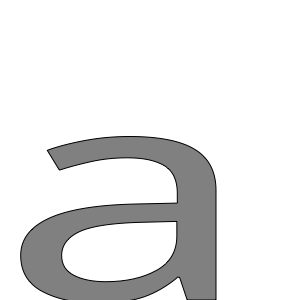

In [51]:
path_orig = glyphcommands(font, "a")
startdraw(300,300)
stretch = 1.5
paths = []
for i in path_orig:
    if i[0] == 'moveTo':
        path = draw.BezierPath()
        x = i[1][0][0] *stretch
        y = i[1][0][1]
        path.moveTo((x,y))
#         print('startpath'+str((i[1][0])))
    if i[0] == 'lineTo':
        x = i[1][0][0] * stretch
        y = i[1][0][1]
        path.lineTo((x,y))
#         print('lineto' +str((x,y)))
    if i[0] == 'qCurveTo':
        temp = []
        for cord in i[1]:
            x = cord[0] * stretch 
            y = cord[1]
            temp.append((x,y))
        path.qCurveTo(*temp)
#         print('qCurveTo' + str(temp))
    if i[0] == 'closePath':
        path.closePath()
        paths.append(path)
#         print('closepath')
finalpath = paths[0].difference(paths[1])
finalpath.scale(0.3) #let's scale it down!
draw.fill(0.5)
draw.stroke(0)
draw.drawPath(finalpath)
show()

Or we can selectively stretch out characters by only modifying points that meet certain criteria. The code in the cell below shifts up all commands whose `y` coordinate lies above 1/3 of the way from the baseline to the ascender height of the font:

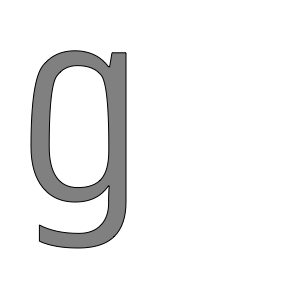

In [52]:
path_orig = glyphcommands(font, "g")
startdraw(300,300)
y_value = 200
paths = []
for i in path_orig:
    if i[0] == 'moveTo':
        path = draw.BezierPath()
        x = i[1][0][0]
        y = i[1][0][1]
        if y >=200:
            y = y + y_value
        path.moveTo((x,y))
#         print('startpath'+str((i[1][0])))
    if i[0] == 'lineTo':
        x = i[1][0][0]
        y = i[1][0][1]
        if y >=300:
            y = y + y_value
        path.lineTo((x,y))
#         print('lineto' +str((x,y)))
    if i[0] == 'qCurveTo':
        temp = []
        for cord in i[1]:
            x = cord[0] 
            y = cord[1]
            if y >=300:
                y = y + y_value
            temp.append((x,y))
        path.qCurveTo(*temp)
#         print('qCurveTo' + str(temp))
    if i[0] == 'closePath':
        path.closePath()
        paths.append(path)
#         print('closepath')
finalpath = paths[0].difference(paths[1])
finalpath.scale(0.2) #let's scale it down!
finalpath.translate(20,100)
draw.fill(0.5)
draw.stroke(0)
draw.drawPath(finalpath)
show()

#### Rendering a modified string

The easiest way to render an entire string with modified glyph paths is to put the path modification code into a function, like so:

In [53]:
def getpath(font, ch, bound, y_value):
    path_orig = glyphcommands(font, ch)
    paths = []
    for i in path_orig:
        if i[0] == 'moveTo':
            path = draw.BezierPath()
            x = i[1][0][0]
            y = i[1][0][1]
            if y >=bound:
                y = y + y_value
            path.moveTo((x,y))
        if i[0] == 'lineTo':
            x = i[1][0][0]
            y = i[1][0][1]
            if y >=bound:
                y = y + y_value
            path.lineTo((x,y))
        if i[0] == 'qCurveTo':
            temp = []
            for cord in i[1]:
                x = cord[0]
                y = cord[1]
                if y >=bound:
                    y = y + y_value
                temp.append((x,y))
            path.qCurveTo(*temp)
        if i[0] == 'closePath':
            path.closePath()
            paths.append(path)
    if len(paths) > 1:
        finalpath = paths[0].difference(paths[1])
    else: 
        finalpath = paths[0]
    return finalpath

This function has a parameter that lets you set the cutoff for deciding whether a command in the path will be offset or not, based on its distance from the baseline.

To draw the whole string, use the code from the simple string layout function above, calling the function to generate the glyph for each character in the string, advancing by the `advance`:

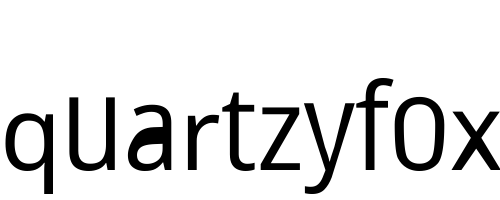

In [54]:
startdraw(500,200)
scale_num = 0.1
y_val = 30
cx = 0
for ch in s:
    glyph_path = getpath(font, ch, uniform(200,300),uniform(0,200))
    glyph_path.scale(scale_num)
    glyph_path.translate(cx,y_val)
    draw.drawPath(glyph_path)
    cx += advancefor(font, ch)*scale_num
show()

#### Modifying a larger path

For some effects, it's beneficial to apply coordinate transformations across the entire path of the string, instead of character-by-character. For this, use the `combine_path()` function introduced above, which returns one big path with all of the paths for the glyphs corresponding to the characters in the string. In the example below, I modify the `y` coordinate of each command in the path by the sine of the `x` coordinate, giving the resulting path a pleasing wave...

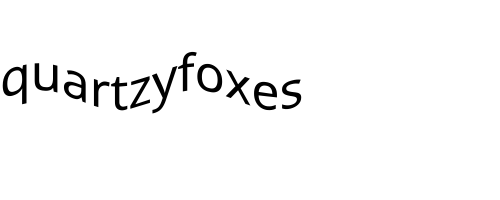

In [55]:
def getpath(font, ch, scale,trans_x,trans_y,x_offset, y_offset):
    path_orig = glyphcommands(font, ch)
    paths = []
#     print(trans_x)
    amp = 200
    period = 0.04
    y_shift = np.sin((trans_x)*0.03)*10
    for i in path_orig:
        if i[0] == 'moveTo':
            path = draw.BezierPath()
            x = i[1][0][0]
            y = i[1][0][1]+np.sin((x*scale + trans_x)*period)*amp
            path.moveTo((x,y))
        if i[0] == 'lineTo':
            x = i[1][0][0]
            y = i[1][0][1]+np.sin((x*scale + trans_x)*period)*amp #?
            path.lineTo((x,y))
        if i[0] == 'qCurveTo':
            temp = []
            for cord in i[1]:
                x = cord[0]
                y = cord[1]+np.sin((x*scale + trans_x)*period)*amp #?
                temp.append((x,y))
            path.qCurveTo(*temp)
        if i[0] == 'closePath':
            path.closePath()
            paths.append(path)
    if len(paths) > 1:
        finalpath = paths[0].difference(paths[1])
    else: 
        finalpath = paths[0]
    finalpath.scale(scale)
    finalpath.translate(trans_x + x_offset,trans_y + y_offset)
    return finalpath

def combine_path(font, s,scale,x_offset,y_offset): 
    text_paths = []
    cx = 0
    for ch in s:
        glyph_path = getpath(font, ch, scale,cx,0,x_offset,y_offset)
        text_paths.append(glyph_path)
        cx += advancefor(font, ch)*scale
    combined = draw.BezierPath()
    for i in text_paths:
        combined.appendPath(i)
    return combined

###############

qf_path = combine_path(font, "quartzyfoxes",0.05,0,100)

# qf_path_cmds = []

startdraw(500,200)

draw.drawPath(qf_path)

show()


Yes, we have reinvented [WordArt](https://en.wikipedia.org/wiki/Microsoft_Office_shared_tools#WordArt).

(Note: "Nudging" the control points of Bézier curves doesn't necessarily produce intuitive results, as you've seen in some of the above examples—the resulting curves aren't quite offset in a linear fashion. The "right" way to do this would be to flatten all of the curves to high-resolution polylines, then perform transformations on those coordinates. But the Bezmerizing library doesn't have an easy way to flatten arbitrary paths to polylines yet, so here we are.)

#### Re-interpreting font commands

One final example. Instead of using the original command in a path, we can "reinterpret" that command as something else. The example below draws lines instead of curves, and circles instead of lines, for each command in a path:

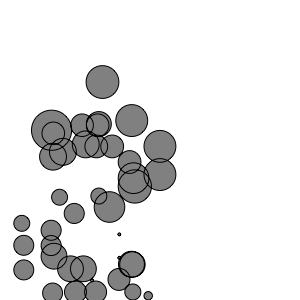

In [56]:
path_orig = glyphcommands(font, "a")
startdraw(300,300)
a = draw.BezierPath()
paths = []
for i in path_orig:
    circlesize = normal(70,25)
    if i[0] == 'moveTo':
        a.oval(x,y,circlesize,circlesize)
    if i[0] == 'lineTo':
        x = i[1][0][0] 
        y = i[1][0][1]
        a.oval(x,y,circlesize,circlesize)
    if i[0] == 'qCurveTo':
        for cord in i[1]:
            x = cord[0] 
            y = cord[1]
            a.oval(x,y,circlesize,circlesize)

a.scale(0.3) #let's scale it down!
draw.fill(0.5)
draw.stroke(0)
draw.drawPath(a)
show()

Drawing all commands as circles:

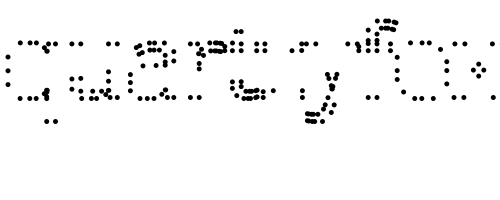

In [57]:
def getpath(font, ch, scale,trans_x,trans_y,x_offset, y_offset,circlesize):
    path_orig = glyphcommands(font, ch)
    paths = []
    for i in path_orig:
        if i[0] == 'moveTo':
            outline = draw.BezierPath()
            x = i[1][0][0]
            y = i[1][0][1]
            outline.oval(x,y,circlesize,circlesize)
        if i[0] == 'lineTo':
            x = i[1][0][0]
            y = i[1][0][1]
            outline.oval(x,y,circlesize,circlesize)
        if i[0] == 'qCurveTo':
            temp = []
            for cord in i[1]:
                x = cord[0]
                y = cord[1]
                outline.oval(x,y,circlesize,circlesize)
        if i[0] == 'closePath':
            path.closePath()
            paths.append(outline)
    if len(paths) > 1:
        finalpath = paths[0].difference(paths[1])
    else: 
        finalpath = paths[0]
    finalpath.scale(scale)
    finalpath.translate(trans_x+x_offset,trans_y+y_offset)
    return finalpath

def combine_path(font, s,scale,x_offset,y_offset,circlesize): 
    text_paths = []
    cx = 0
    for ch in s:
        glyph_path = getpath(font, ch, scale,cx,0,x_offset,y_offset,circlesize)
        text_paths.append(glyph_path)
        cx += advancefor(font, ch)*scale
    combined = draw.BezierPath()
    for i in text_paths:
        combined.appendPath(i)
    return combined

###############

qf_path = combine_path(font, "quartzyfoxes",0.1,0,100,50)

# qf_path_cmds = []

startdraw(500,200)

draw.drawPath(qf_path)

show()


## Further resources

For a general introduction to digital typography, I highly recommend [Simon Cozen's *Fonts and Layout for Global Scripts*](https://simoncozens.github.io/fonts-and-layout/). The [history chapter](https://simoncozens.github.io/fonts-and-layout//history.html) is especially insightful and well-researched.

More on digital representations of typefaces:

* [UFO](http://unifiedfontobject.org/versions/ufo3/), a contemporary file format for fonts
* [FreeType Glyph
  Conventions](https://www.freetype.org/freetype2/docs/glyphs/index.html) is documentation for FreeType (a widely-used glyph rendering library), but also a good introduction to digital typography in general
* [An Introduction to TrueType Fonts: A look inside the TTF format](https://scripts.sil.org/cms/scripts/page.php?site_id=nrsi&id=IWS-Chapter08)
* [Bézier Curves and Type Design: A Tutorial](https://learn.scannerlicker.net/2014/04/16/bezier-curves-and-type-design-a-tutorial/)
* [Typography in 8 bits: System fonts](https://damieng.com/blog/2011/02/20/typography-in-8-bits-system-fonts)

Artworks engaging font data:

* [Leslie Mezei, Babel Shook](https://www.atariarchives.org/artist/sec7.php)
* [Eduardo Kac, Accident, 1994](http://www.ekac.org/accident.html)
* [Jürg Lehni & Alex Rich, Empty words, 2008](http://juerglehni.com/works/empty-words)
* [Zach Lieberman et al, IQ Font](http://thesystemis.com/projects/iq-font/)
* [BalletFont](https://web.archive.org/web/20160812072806/http://www.creativeapplications.net/openframeworks/balletfont-openframeworks/) ([making-of video](https://youtu.be/-DdAp26lmIU))